# Exploratory Data Analysis, Preprocessing, Feature Engineering

In [33]:
# imports

# dataframe
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# preprocessing

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

nltk.download(['stopwords', 'wordnet', 'omw-1.4'], download_dir='.')
# print('before:', nltk.data.path)
if '.' not in nltk.data.path:
    nltk.data.path.append('.')
# print('after:', nltk.data.path)

import regex as re
import string

# visualization with word clouds
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to ....
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ....
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ....
[nltk_data]   Package omw-1.4 is already up-to-date!


### Exploratory data analysis

In [34]:
# read dataset
dataset = pd.read_csv('../Dataset/Tweets.csv', encoding='ISO-8859-1')

In [35]:
# 10 random examples from the dataset
dataset.sample(10)

,textID,text,selected_text,sentiment
1592,c7739e2dbc,just finishing studying for LSATs and watching...,just finishing studying for LSATs and watching...,neutral
3625,18170c1a3c,Time for a clean up.,Time for a clean up.,neutral
10859,7719118f71,just waking up...ahh i have a headache,headache,negative
15538,9ff3e87437,and it is raining in Denver. of COURSE it is,and it is raining in Denver. of COURSE it is,neutral
6679,b541db1127,it wouldnt let me vote yesterday but i made ...,y hope,positive
368,f38f53fbde,had a great time out in the beer garden wit th...,had a great time out in the beer garden wit th...,neutral
2967,b43a159bfe,Chabibi. It`s a long running joke. I don`t gi...,Chabibi. It`s a long running joke. I don`t giv...,neutral
14563,dbf9e18872,_KHC wooow. lucky XD my break is gonna end. my...,lucky,positive
20592,3f2f7b0c14,"Going to bed, in pain fell on my shoulder toda...","Going to bed, in pain fell on my shoulder toda...",neutral
4672,886d0c07ed,"_ yeah, just knew him because of your link HE...",HE`S COMPLETELY AMAZING,positive


In [36]:
# dataset characteristics
print(dataset.info())
display(dataset.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None


,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


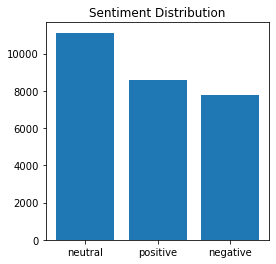

In [37]:
# distribution of classes (positive, neutral, negative )

sentiment_counts = dataset['sentiment'].value_counts()
plt.figure(figsize=(4,4))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title("Sentiment Distribution")
plt.show()

### Preprocessing

In [38]:
# drop unneeded columns

# before drop
display(dataset.head(3))

dataset_drop = dataset.drop(['textID', 'selected_text'], axis=1)

# after drop
display(dataset_drop.head(3))

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative


,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative


In [39]:
# don't remove some stop words that might make a difference in positive/negative classification
stop_words_keep = {'against', 'before', 'after', 'up', 'down', 'in', 'out', 'on', 'off', 
                    'no', 'nor', 'not', 'only', 'don\'t', 'aren\'t', 'couldn\'t', 'didn\'t', 
                    'doesn\'t', 'hadn\'t', 'hasn\'t', 'isn\'t', 'mightn\'t', 'mustn\'t', 
                    'needn\'t', 'shan\'t', 'shouldn\'t', 'wasn\'t', 'weren\'t', 'won\'t', 
                    'wouldn\'t'}

sw = stopwords.words("english")
stop_words = [w for w in sw if w not in stop_words_keep]

In [40]:
# a small test of removing stopwords from one example
ex_text = dataset_drop['text'][0].lower().strip().split()
print(ex_text)
print([w for w in ex_text if w not in stop_words])

['i`d', 'have', 'responded,', 'if', 'i', 'were', 'going']
['i`d', 'responded,', 'going']


In [41]:
# preprocessing function

def preprocess(text, remove_apos_backtick=True, lemmatize=True, stem=True, rem_len_1=True, rem_stop_words=True):
    
    # create lemmatizer and stemmer.
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer("english")
    
    # regex patterns.
    url_pattern         = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern        = '@[^\s]+'
    alpha_pattern       = "[^a-zA-Z0-9`\']" # keep back ticks (` used instead of ' in the dataset) and apostrophes (')
    sequence_pattern    = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"
    
    # lowercasing
    text = str(text).lower()
    
    # replace apostrophes and backticks with empty string
    if remove_apos_backtick:
        text = re.sub('[\'`]', '', text)

    # replace all URls with 'URL'
    text = re.sub(url_pattern, ' URL ',text)
         
    # replace @USERNAME to 'USER'.
    text = re.sub(user_pattern, ' USER ', text)        

    # replace all non letters, non numbers (except backticks and apostrophes)
    text = re.sub(alpha_pattern, ' ', text)

    # replace 3 or more consecutive characters by 2 of that character
    text = re.sub(sequence_pattern, seq_replace_pattern, text)

    preproc_text = ''

    # for each word in text
    for word in text.split():
        
        # ignore words of length 1
        if len(word) > 1 or not rem_len_1:

            # lemmatize
            if lemmatize:
                word = lemmatizer.lemmatize(word)

            # check if stopword
            if word not in stop_words or not rem_stop_words:

                # stem 
                if stem:
                    word = stemmer.stem(word)
                    
                preproc_text += (word + ' ')
        
    return preproc_text

In [42]:
# apply preprocessing to a dataset copy

dataset_preproc = dataset_drop.copy(deep=True)
dataset_preproc['text'] = dataset_preproc['text'].apply(lambda t: preprocess(t, stem=True))

In [43]:
# manually compare original text to preprocessed text to see if positive/negative meaning is lost or kept
# use vscode's jupyter variable viewer or some other tool

compare_preproc = pd.concat([dataset_preproc['text'], dataset_drop], axis=1)
compare_preproc.columns = ['preprocessed text', 'original text', 'sentiment']
compare_preproc.sample(3)

,preprocessed text,original text,sentiment
22067,like idea elimin bludger beater tackl ppl make...,I like the idea of eliminating bludgers and b...,negative
7578,happi momi day,happy momies day!,positive
4884,start work miss like crazi wont see till tuesday,about to start work and missing him like crazy...,negative


### Word token visualization with word clouds

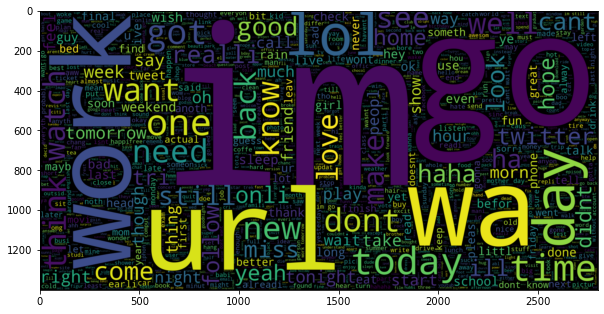

In [64]:
# neutral sentiment tweet words

plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 2800 , height = 1400).generate(" ".join(dataset_preproc[dataset_preproc['sentiment'] == 'neutral']['text']))
plt.imshow(wc , interpolation = 'bilinear')

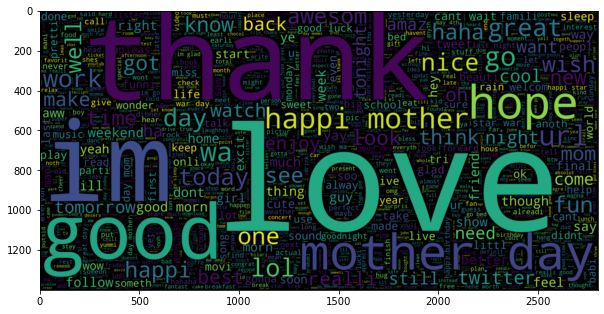

In [65]:
# positive sentiment tweet words

plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 2800 , height = 1400).generate(" ".join(dataset_preproc[dataset_preproc['sentiment'] == 'positive']['text']))
plt.imshow(wc , interpolation = 'bilinear')

# note: collocations
# see how "mother day" and "happi mother" appear together, these are collocations (frequently grouped words)
# can disable with collocations=False in the WordCloud constructor call

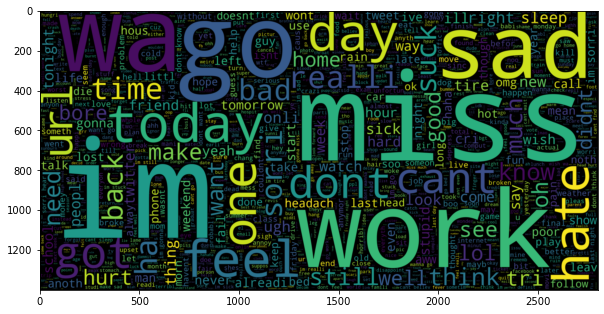

In [66]:
# negative sentiment tweet words

plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 2800 , height = 1400).generate(" ".join(dataset_preproc[dataset_preproc['sentiment'] == 'negative']['text']))
plt.imshow(wc , interpolation = 'bilinear')

### Feature Engineering

In [47]:
# feature: # punctuation characters / total # of characters

def punct_ratio(text):

    text = str(text)

    p_count = 0

    for c in text:
        if c in string.punctuation:
            p_count += 1

    return p_count / len(text)

In [48]:
punct_ratio_feature = dataset['text'].apply(lambda t: punct_ratio(t)).rename('punct_ratio')

In [49]:
# feature: # of instances of consecutive punctuation

# can specifiy minimum number of consecutive punctuation to count as a consecutive instance
def num_consec_punct(text, min_consec_punct=2):

    text = str(text)

    base_pattern = '[' + re.escape('!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~') + ']'

    pattern = base_pattern * min_consec_punct + '+'

    return len(re.findall(pattern, text)) 

In [50]:
num_consec_punct_feature = dataset['text'].apply(lambda t: num_consec_punct(t)).rename('num_consec_punct')

In [51]:
# feature: # capital letters / total # of characters

def capital_ratio(text):

    text = str(text)

    cap_count = 0

    for c in text:
        if c in string.ascii_uppercase:
            cap_count += 1

    return cap_count / len(text)

In [52]:
capital_ratio_feature = dataset['text'].apply(lambda t: capital_ratio(t)).rename('capital_ratio')

In [53]:
# feature: number of words

def num_words(text):

    return len(str(text).split())

In [54]:
num_words_before_preproc_feature = dataset['text'].apply(lambda t: num_words(t)).rename('num_words_before_preproc')

In [55]:
num_words_after_preproc_feature = dataset_preproc['text'].apply(lambda t: num_words(t)).rename('num_words_after_preproc')

In [56]:
# feature: average word length 

def avg_word_len(text):

    words = str(text).split()

    len_sum = 0

    for w in words:
        len_sum += len(w)

    return 0 if len_sum == 0 else len_sum / len(words)

In [57]:
avg_word_len_before_preproc_feature = dataset['text'].apply(lambda t: avg_word_len(t)).rename('avg_word_len_before_preproc')

In [58]:
avg_word_len_after_preproc_feature = dataset_preproc['text'].apply(lambda t: avg_word_len(t)).rename('avg_word_len_after_preproc')

In [59]:
# feature: # stop words before preprocessing / total # words

def stop_word_ratio(text):

    words = str(text).split()

    num_stop_words = 0

    for w in words:
        if w in stop_words:
            num_stop_words += 1

    return 0 if len(words) == 0 else num_stop_words / len(words)

In [60]:
stopword_ratio_feature = dataset['text'].apply(lambda t: stop_word_ratio(t)).rename('stop_word_ratio')

In [61]:
compare_features = pd.concat([punct_ratio_feature, 
                              num_consec_punct_feature,
                              capital_ratio_feature, 
                              num_words_before_preproc_feature,
                              num_words_after_preproc_feature,
                              avg_word_len_before_preproc_feature,
                              avg_word_len_after_preproc_feature,
                              stopword_ratio_feature,
                              dataset_preproc], axis=1)

In [62]:
# compare mean feature values by class label

display(compare_features.groupby('sentiment', as_index=False).mean())

,sentiment,punct_ratio,num_consec_punct,capital_ratio,num_words_before_preproc,num_words_after_preproc,avg_word_len_before_preproc,avg_word_len_after_preproc,stop_word_ratio
0,negative,0.054953,0.529752,0.041340,13.473204,8.208199,4.363381,4.342662,0.285801
1,neutral,0.053076,0.448732,0.043630,12.342867,7.521587,4.473515,4.343495,0.283306
2,positive,0.052964,0.477278,0.048681,13.109881,8.115358,4.549553,4.467203,0.274992


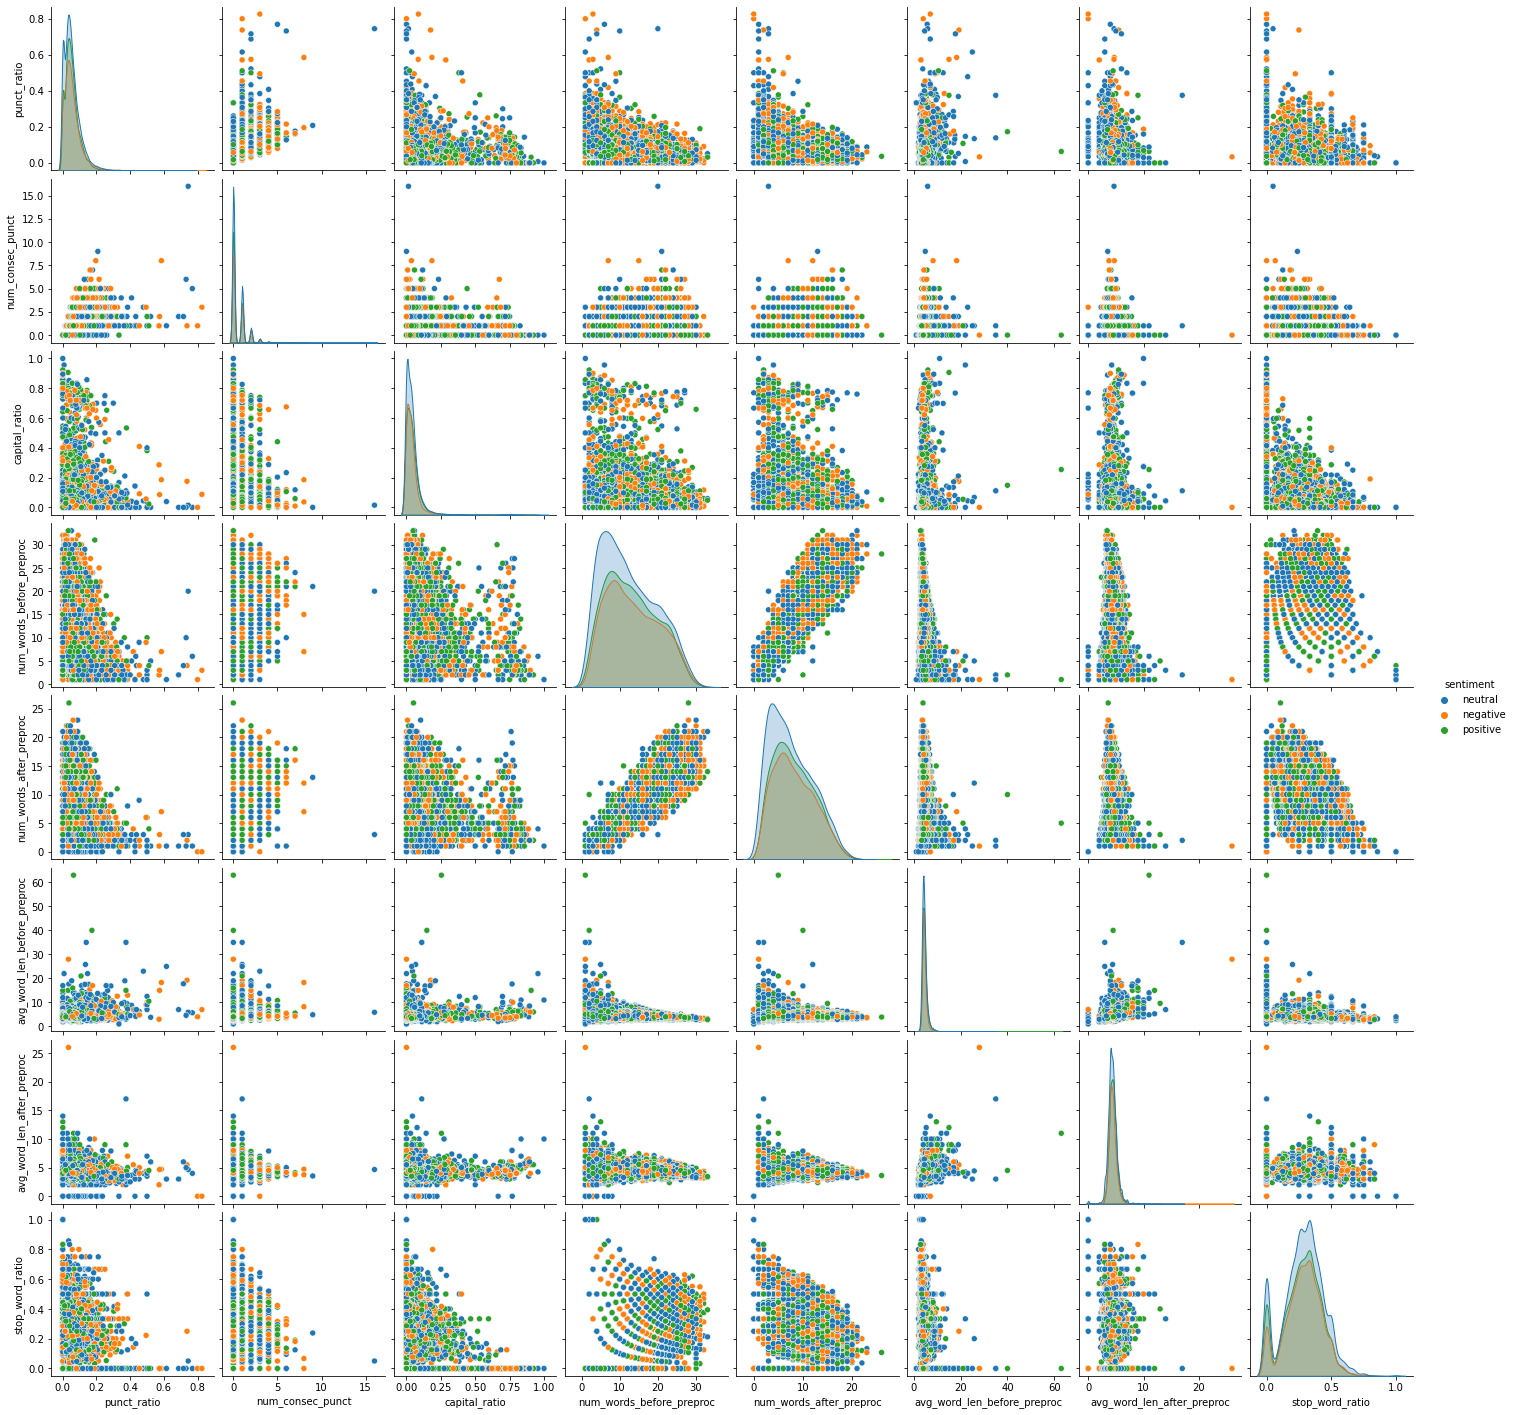

In [63]:
# plot features

import seaborn as sns
sns.pairplot(compare_features, hue='sentiment')